In [1]:
import pandas as pd
from astropy.coordinates import SkyCoord
import numpy as np
from matplotlib import pyplot as plt
import time

# full-sky density calculation

func

In [5]:
def density_sky_calculation(data='a',coor='icrs',bin=1,bins=360):
    # read path
    with open('/media/hyz/dwarfcave/data/gaiaDR3/ms/gaiasource_path.list','r') as _list:
        path = _list.readlines()
        if type(data) == int:
            path = path[0:data]
        elif data == 'a':
            pass
        
    # make grid
    if bin == 1:
        if bins == 360:
            pass
        else:
            bin = 360/bins
    else:
        bins = np.floor(360/bin)
    grid = np.zeros((bins,np.int16(bins/2)))
    
    # statistics
    for _line in path:
        _p = _line.strip()
        print("reading ==> ",_p)
        _data = pd.read_csv(_p,comment='#',usecols=['ra','dec'])
        _data['dec'] += 90  # 将赤维从[-90,90]转化为[0,180]
        _data['ra'] = np.int16(_data['ra']/bin)
        _data['dec'] = np.int16(_data['dec']/bin)
        _ragrid = np.arange(_data['ra'].min(),_data['ra'].max()+1,1)
        _decgrid = np.arange(_data['dec'].min(),_data['dec'].max()+1,1)
        for _rgi in _ragrid:
            for _dgi in _decgrid:
                grid[_rgi,_dgi] += np.sum((_data['ra']==_rgi) & (_data['dec']==_dgi))
    
    # coordinate alternation
    if coor == 'icrs':
        return grid
    elif coor == 'gal':
        grid_ra = np.arange(0,360,bin)
        grid_dec = np.arange(-90,90,bin)
        grid_icrs = SkyCoord(grid_ra,grid_dec,frame='icrs',unit='deg')
        grid_gal = grid_icrs.galactic
        grid = grid_gal.to_string('decimal')
        return grid
    else:
        print('coordination assign is out of index, please choose "icrs" or "gal".')

main

In [ ]:
if __name__ == "__main__":
    grid = density_sky_calculation('a')

plot

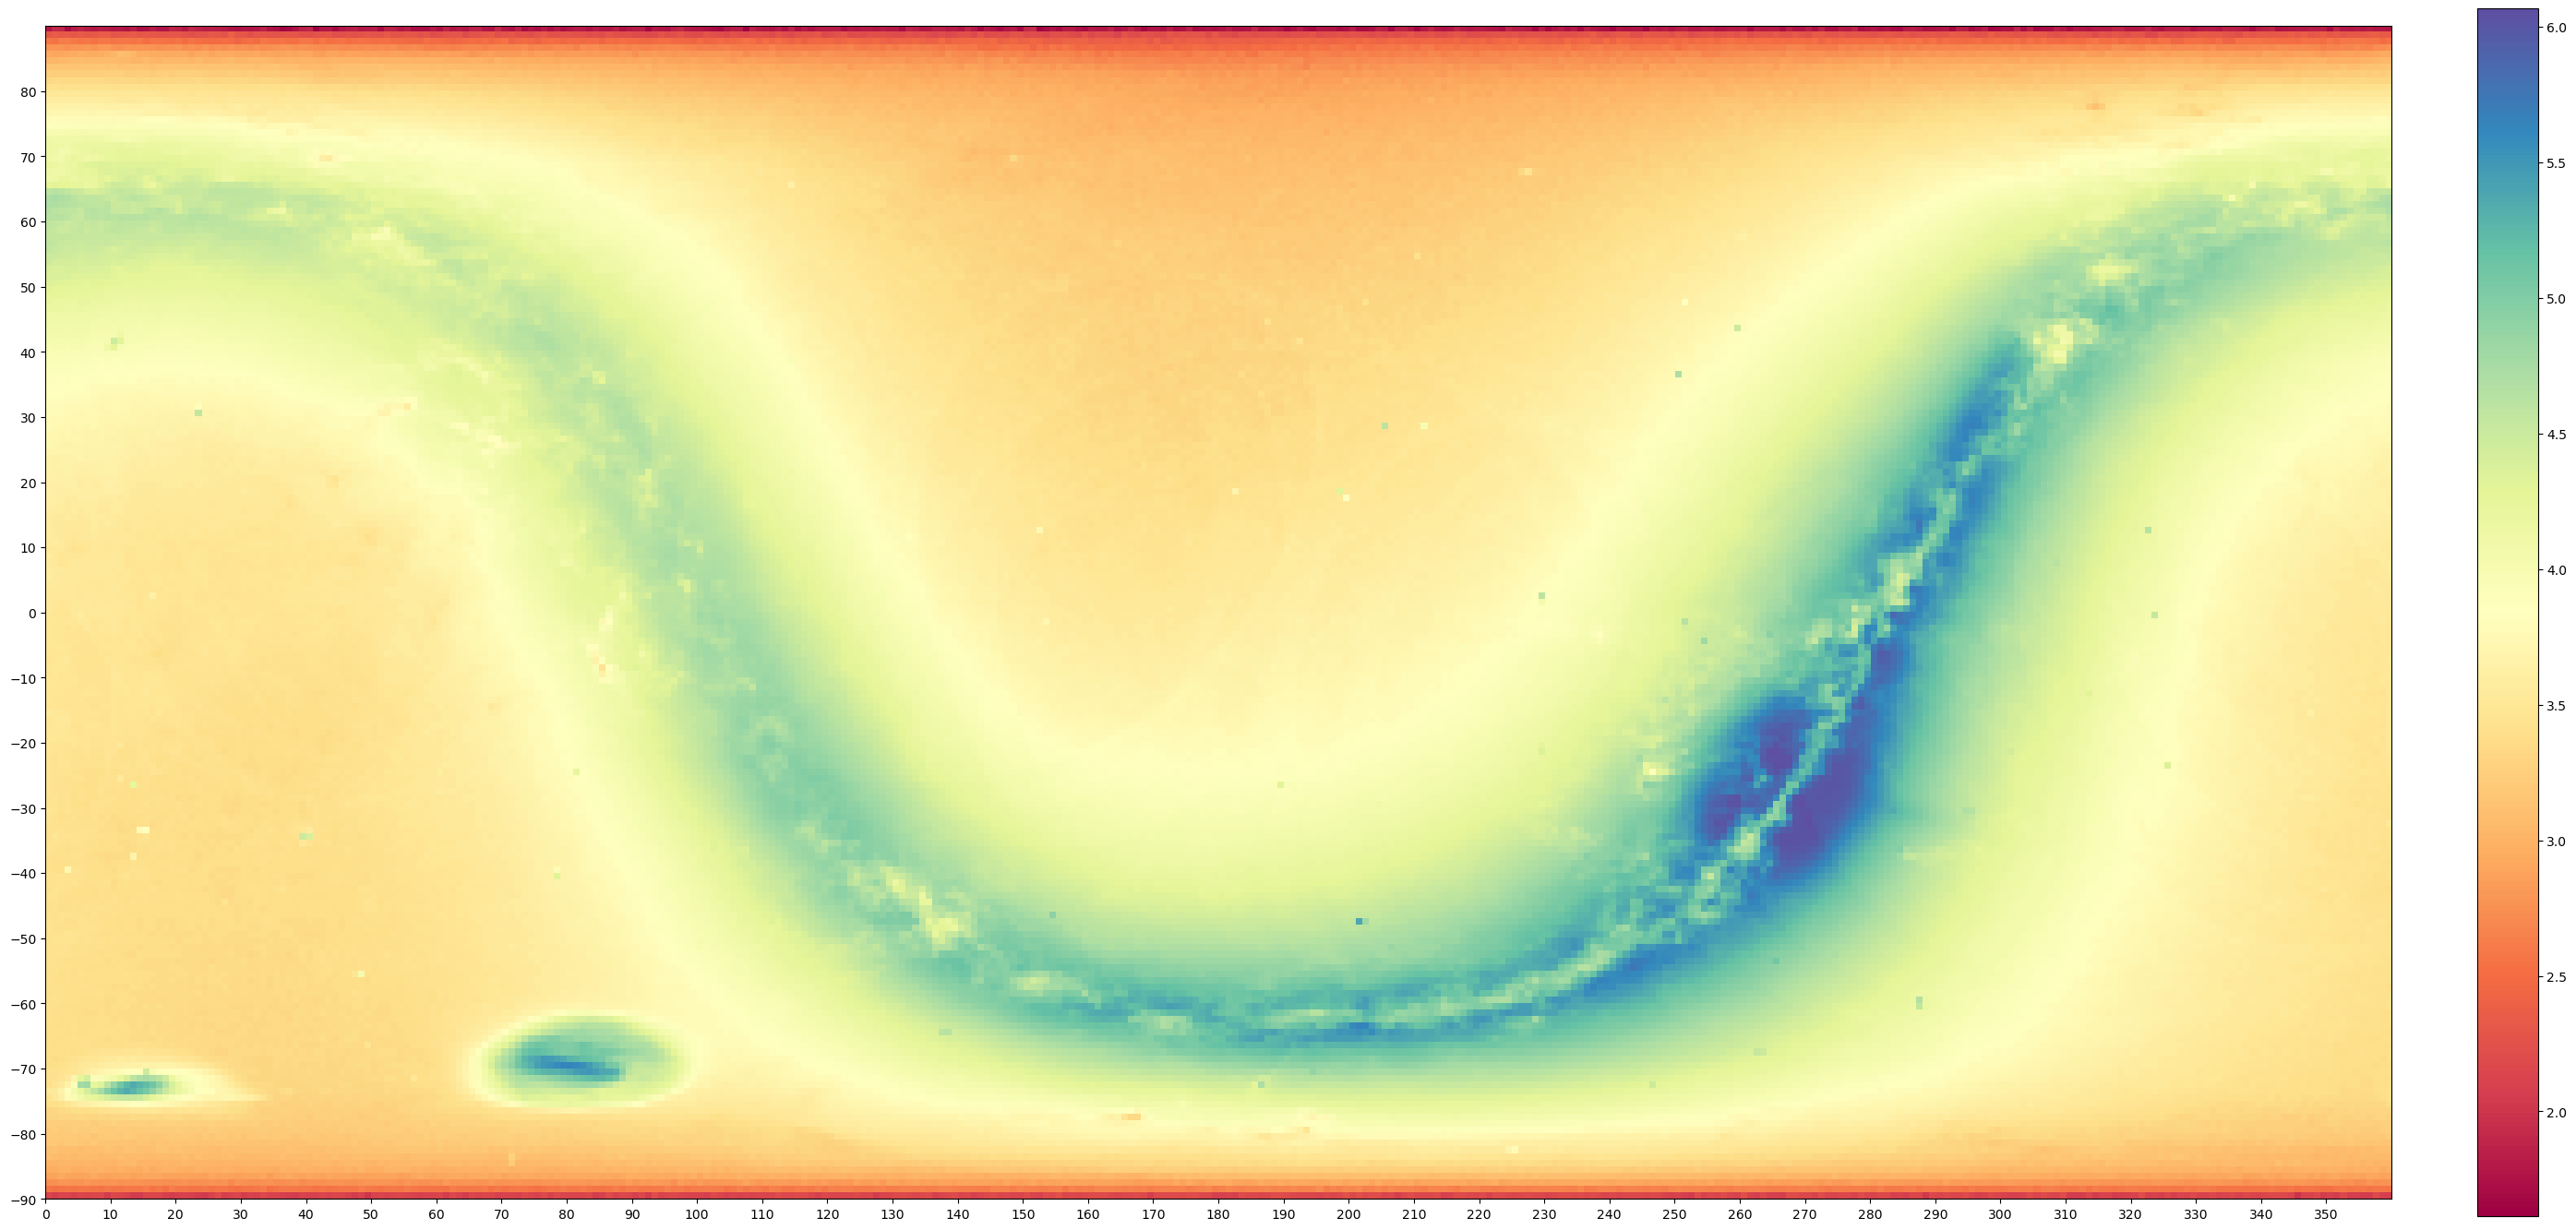

In [11]:
plt.figure(figsize=(40,20))
plt.yticks(np.arange(-90,90,10))
plt.xticks(np.arange(0,360,10))
plt.ylim((-90,90))
plt.imshow(np.log10(grid+1).T,cmap='Spectral',extent=(0,360,-90,90),origin='lower')
plt.colorbar(shrink=0.85,pad=0.03)
plt.savefig('./gaia_fullsky_source_density.png')

save

In [12]:
np.save('gaia_fullsky_source_density.npy',grid)

In [16]:
with open('gaia_fullsky_source_density.txt','w') as w:
    head = '# created by hyz in 22.12.1' + '\n# max: %s    min: %s    mean: %s    std: %s\n'\
            %(grid.max(),grid.min(),grid.mean(),grid.std())
    w.writelines(head)
    for i in grid:
        w.writelines(str(i)+'\n')

In [ ]:
dd = np.array(np.where(grid>=1e6)).T
numl = []
for i in dd:
    numl.append(grid[i[0],i[1]])
numl = np.array(numl).reshape(-1,1)
position = dd-[0,90]
densPsquare = np.hstack((position,numl))
densPsquare

In [ ]:
from astropy.io import fits


hdu = fits.PrimaryHDU()
hdu.header['descrip'] = 'gaia main source full-sky density in unit of square-deg'
hdu.header['author'] = 'hyz'
hdu.header['time'] = '2022.12.1'
hdu2 = fits.ImageHDU(grid)
hdul = fits.HDUList([hdu,hdu2])
hdul.writeto('gaia_fullsky_source_density.fits')

# magnitude density calculation

func

In [1]:
def float2index(d,bin,min):
    # d = d.fillna(99)  # fill nan in mag with value 99.
    return np.int16((d-min)/bin)

def density_mag_calculation(data='a', m_min=-2, m_max=30, bin=0.01):
    """bin could reach 0.001 to most."""
    # read path
    with open('/media/hyz/dwarfcave/data/gaiaDR3/ms/gaiasource_path.list','r') as _list:
        path = _list.readlines()
        if type(data) == int:
            path = path[0:data]
        elif data == 'a':
            pass
        
    # make grid
    magax = np.arange(m_min,m_max,bin)
    bins = magax.size
    numax = np.zeros((bins,3))  # g_ax, rp_ax, bp_ax
    # statistics
    for _,_line in enumerate(path):
        _p = _line.strip()
        print("reading:%s ==> "%_,_p)
        _data = pd.read_csv(_p,comment='#',usecols=['phot_g_mean_mag','phot_rp_mean_mag','phot_bp_mean_mag'])
        _data = float2index(_data,bin,m_min)
        _gax = np.arange(_data[:,0].min(),_data[:,0].max()+1,1)
        _rpax = np.arange(_data[:,1].min(),_data[:,1].max()+1,1)
        _bpax = np.arange(_data[:,2].min(),_data[:,2].max()+1,1)
        for _i in _gax:
            numax[_i,0] += np.sum(_data[:,0]==_i)
        for _i in _rpax:
            numax[_i,1] += np.sum(_data[:,1]==_i)
        for _i in _bpax:
            numax[_i,2] += np.sum(_data[:,2]==_i)
    numax[0] = [0,0,0]

    den_mag_sta = np.hstack((magax.reshape(-1,1),numax))
    den_mag_sta = pd.DataFrame(den_mag_sta,columns=['mag','num g','num rp','num bp'])
    return den_mag_sta

main

In [4]:
if __name__ == '__main__':
    startt = time.time()
    result = density_mag_calculation('a')
    result.to_csv('gaia_mag_density.csv')
    rn = result.to_numpy(copy=True)
    np.save('gaia_mag_density.npy',rn)
    tu = time.time() - startt
    print('----------------time used: %.02fs / %.02fh'%(tu,tu/3600))


reading:0 ==>  /media/hyz/dwarfcave/data/gaiaDR3/ms/GaiaSource_000000-003111.csv
reading:1 ==>  /media/hyz/dwarfcave/data/gaiaDR3/ms/GaiaSource_003112-005263.csv


In [6]:
d = np.load('/home/hyz/da/gaia/density_statistics/gaia_mag_density.npy')

plot

In [ ]:
linear = np.polyfit(d[:,0][6*100:22*100],np.log10(d[:,1][6*100:22*100]/648),1)


plt.figure(figsize=(12,8))
plt.title('source density with mag in full-sky of gaia')
plt.plot(d[:,0],np.log10(d[:,1]/648),'g',label='g')
plt.plot(d[:,0],np.log10(d[:,2]/648),'b',label='bp')
plt.plot(d[:,0],np.log10(d[:,3]/648),'r',label='rp')
plt.plot(np.arange(-2,30,0.1),linear[0]*np.arange(-2,30,0.1)+linear[1],'g--',label='g-fit')  # g-fit
plt.xticks(np.arange(-2,30,1))
plt.yticks(np.arange(-3,4.5,0.1))
plt.ylim((-3,4.5))
plt.grid()
plt.legend()
plt.ylabel('log10(num /deg^2/mag)')
plt.xlabel('mag')
plt.savefig('gaia_mag_density.png')

# full-sky magnitude density calculation

func self-defined
* comment: speed slow.... to death ---- about 3min for one file

In [ ]:
dty = np.int32

def float2index(d,bin,min=0):
    # d = d.fillna(99)  # fill nan in mag with value 99.
    return dty((d-min)/bin)

def density_sky_mag_calculation(data='a',coor='icrs',bin_sky=1,m_min=1, m_max=25, bin_mag=0.01):
    # read path
    with open('/media/hyz/dwarfcave/data/gaiaDR3/ms/gaiasource_path.list','r') as _list:
        path = _list.readlines()
        if type(data) == int:
            path = path[0:data]
        elif data == 'a':
            pass
        
    # make grid
    bins_sky = np.arange(0,360,bin_sky).size
    bins_mag = np.arange(m_min,m_max,bin_mag).size
    count    = np.zeros((int(bins_sky/2),bins_sky,bins_mag,4),dtype=dty)  # ra,dec,[mag]. mag:(in colume) magbins g rp bp mean

    # sky_ax = np.array(np.meshgrid(np.arange(0,360,1),np.flip(np.arange(-90,90,1))),dtype=np.float32).T
    
    # statistics
    for _,_line in enumerate(path):
        _p = _line.strip()
        # read
        print("reading:%s ==> "%_,_p)
        _d    = pd.read_csv(_p,comment='#',usecols=['ra','dec','phot_g_mean_mag','phot_rp_mean_mag','phot_bp_mean_mag'])
        _d['mag_mean'] = _d[['phot_g_mean_mag','phot_rp_mean_mag','phot_bp_mean_mag']].mean(axis=1)  # calculate mean of 3 band. obtain all objects
        _d = _d.fillna(1)
        # index
        _bin  = [bin_sky,bin_sky,bin_mag,bin_mag,bin_mag,bin_mag]
        _min  = [0, -90, m_min, m_min, m_min, m_min]
        _d    = float2index(_d, _bin, _min)
        # region
        _mml  = np.array([np.arange(_d[:,0].min(),_d[:,0].max(),1),   # seperatly ra, dec, g, rp, bp, mean
                          np.arange(_d[:,1].min(),_d[:,1].max(),1),
                          np.arange(_d[:,2].min(),_d[:,2].max(),1),
                          np.arange(_d[:,3].min(),_d[:,3].max(),1),
                          np.arange(_d[:,4].min(),_d[:,4].max(),1),
                          np.arange(_d[:,5].min(),_d[:,5].max(),1)])  # lengths of these series are not identity, so dtype is object.
        # add
        for _de in _mml[1]:                                                                     # dec
            for _r in _mml[0]:                                                                 # ra
                if _de%10==0 and _r%10==0:
                    print(_de,_r)
                for _m in _mml[2]:
                    count[_de,_r,_m,0] += np.sum((_d[:,0]==_r) & (_d[:,1]==_de) & (_d[:,2]==_m))  # g
                for _m in _mml[3]:
                    count[_de,_r,_m,1] += np.sum((_d[:,0]==_r) & (_d[:,1]==_de) & (_d[:,2]==_m))  # rp
                for _m in _mml[4]:
                    count[_de,_r,_m,2] += np.sum((_d[:,0]==_r) & (_d[:,1]==_de) & (_d[:,2]==_m))  # bp
                for _m in _mml[5]:
                    count[_de,_r,_m,3] += np.sum((_d[:,0]==_r) & (_d[:,1]==_de) & (_d[:,2]==_m))  # mean
    
    magax = np.arange(m_min,m_max,bin_mag,dtype=np.float32)
    # coordinate alternation
    if coor == 'icrs':
        return [magax, count]
    elif coor == 'gal':
        grid_ra = np.arange(0,360,bin)
        grid_dec = np.arange(-90,90,bin)
        grid_icrs = SkyCoord(grid_ra,grid_dec,frame='icrs',unit='deg')
        grid_gal = grid_icrs.galactic
        count = grid_gal.to_string('decimal')
        return magax, count
    else:
        print('coordination assign is out of index, please choose "icrs" or "gal".')
        
if __name__ == '__main__':
    startt = time.time()
    magax, result = density_sky_mag_calculation(1,bin_mag=0.1)
    result.to_csv('gaia_fullsky_mag_density_rough.csv')
    rn = result.to_numpy(copy=True)
    np.save('gaia_fullsky_mag_density_rough.npy',rn)
    tu = time.time() - startt
    print('----------------time used: %.02fs / %.02fh'%(tu,tu/3600))

func with numpy.histogramdd
* fast to fly

In [ ]:
dty = np.uint16
def float2index(d,bin,min=0):
    # d = d.fillna(99)  # fill nan in mag with value 99.
    return dty((d-min)/bin)

def density_sky_mag_calculation(data='a',mode='m',coor='icrs',bin_sky=1,m_min=2, m_max=25, bin_mag=0.01):
    '''
    data='a' or number of files
    mode='g','r','b','m','a'
    '''
    # read path
    with open('/media/hyz/dwarfcave/data/gaiaDR3/ms/gaiasource_path.list','r') as _list:
        path = _list.readlines()
        if type(data) == int:
            path = path[0:data]
        elif data == 'a':
            pass
    
    bins  = np.array([360/bin_sky,180/bin_sky,(m_max-m_min)/bin_mag],dtype=np.uint16)
    range = ([0,360],[-90,90],[m_min,m_max])
    count_g,count_r,count_b,count_m = np.empty(bins),np.empty(bins),np.empty(bins),np.empty(bins)
    edges = np.histogramdd(np.empty((1,3)),bins,range)[1]
    
    # statistics
    for _,_line in enumerate(path):
        _p = _line.strip()
        print("reading:%s ==> "%_,_p)
        _d    = pd.read_csv(_p,comment='#',usecols=['ra','dec','phot_g_mean_mag','phot_rp_mean_mag','phot_bp_mean_mag'])
        _d['phot_all_mean_mag'] = _d[['phot_g_mean_mag','phot_rp_mean_mag','phot_bp_mean_mag']].mean(axis=1)  # calculate mean of 3 band. obtain all objects
        _d = _d.fillna(m_min).to_numpy()
        if mode == 'a':
            count_g = np.array(np.histogramdd(_d[:,[0,1,2]], bins=bins, range=range)[0] + count_g, dtype=dty)
            count_r = np.array(np.histogramdd(_d[:,[0,1,3]], bins=bins, range=range)[0] + count_r, dtype=dty)
            count_b = np.array(np.histogramdd(_d[:,[0,1,4]], bins=bins, range=range)[0] + count_b, dtype=dty)
            count_m = np.array(np.histogramdd(_d[:,[0,1,5]], bins=bins, range=range)[0] + count_m, dtype=dty)
        if mode == 'm':
            if _ == 0:
                del count_g,count_r,count_b
            count_m = np.array(np.histogramdd(_d[:,[0,1,5]], bins=bins, range=range)[0] + count_m, dtype=dty)
        if (_+1)%10 == 0:
            ti = time.time() - start
            print('used time in:  %s =====>\t\t\t%.02fs / %.02fh\n'%(_+1,ti,ti/3600)+'-'*30)
    if mode == 'a':
        count_g[:,:,0] = 0
        count_r[:,:,0] = 0
        count_b[:,:,0] = 0
        count_m[:,:,0] = 0
        count = np.array([count_g,count_r,count_b,count_m],dtype=dty)
    if mode == 'm':
        count_m[:,:,0] = 0
        count = count_m
    
    # coordinate alternation
    if coor == 'icrs':
        return [edges, count]
    # elif coor == 'gal':
    #     grid_ra = np.arange(0,360,bin)
    #     grid_dec = np.arange(-90,90,bin)
    #     grid_icrs = SkyCoord(grid_ra,grid_dec,frame='icrs',unit='deg')
    #     grid_gal = grid_icrs.galactic
    #     count = grid_gal.to_string('decimal')
    #     return [edges, count]
    else:
        print('coordination assign is out of index, please choose "icrs" or "gal".')
        


In [ ]:
if __name__ == '__main__':
    start = time.time()
    edge, h = density_sky_mag_calculation(data='a',mode='a',bin_sky=0.2,bin_mag=0.1,m_min=10,m_max=21)
    end = time.time()
    tm = end - start
    print('----------------time in main func: %.02fs / %.02fh'%(tm,tm/3600))
    np.set_printoptions(threshold=np.inf)
    save_pre = 'gaia_fullsky_mag_density_allband_skyclear_02_01_10-20.5'
    np.save('%s.npy'%save_pre, h)
    np.save('%s.edge.npy'%save_pre, np.array(edge))
    with open('%s.txt'%save_pre,'w') as w:
        header = '# gaia star density with sky and mag.sky by 1 and mag by 0.01.[all band]\n# created by hyz in 2022.12.2\n\ngrid:'
        w.write(header)
        for i in edge:
            w.write('  ('+str(i.max())+', '+str(i.min())+'), '+str(i[:].size))
        w.write('\n')
        for _,_h in enumerate(h):
            for _i,i in enumerate(_h):
                for _j,j in enumerate(i):
                    if _ == 0:
                        w.write('band: -----> g'.ljust(15))
                    elif _ == 1:
                        w.write('band: -----> r'.ljust(15))
                    elif _ == 2:
                        w.write('band: -----> b'.ljust(15))
                    elif _ == 3:
                        w.write('band: -----> m'.ljust(15))
                    w.write('icrs: ------> '+str(edge[0][_i])+', '+str(edge[1][_j])+'\n')
                    w.write(str(j)+'\n')

    tw = time.time() - end
    tu = time.time() - start
    print('----------------time in write: %.02fs / %.02fh'%(tw,tw/3600))
    print('----------------time overused: %.02fs / %.02fh'%(tu,tu/3600))
    
    
#TODO: make changes:
# line10, m_min  -> 2
# line34, fillna -> m_min
# line48-... turn first lines of mag to 0
# line85, write rule
# line74,75,99,101, time show


# scale lense

In [110]:
try:
    dty
except:
    dty = np.uint64

def scale_rougher(data,times):
    """
    aiming at histogram scale change, to make it rougher, equal to a bigger bin.
    data: histogramed data
    times: rougher times [int]
    """
    l = len(data)
    data = data[:l//times*times]
    return data.reshape(-1,times).sum(axis=1)

sr = scale_rougher

def scale_rougher_gaia_fmd(edge,hist,times,mode='mag',band='all'):
    """
    path of edge, hist file, and times in need.
    mode = 'ra','dec','sky' or 'mag'
    band = 'all', 'single', 'g', 'r', 'b'
    """
    edge = np.load(edge,allow_pickle=True)
    hist = np.load(hist)
    if band == 'all':
        if mode == 'mag':
            edge[2] = edge[2][:-1].reshape(-1,times)[:,0]
            hs= hist.shape
            print(hs)
            hist = hist[:,:,:,:hs[3]//times*times].reshape(hs[0],hs[1],hs[2],-1,times).sum(axis=4)
            return [edge,hist]
    if band == 'single':
        if mode == 'mag':
            edge[2] = edge[2][:-1].reshape(-1,times)[:,0]
            hs= hist.shape
            print(hs)
            hist = hist[:,:,:hist.shape[2]//times*times].reshape(hs[0],hs[1],-1,times).sum(axis=3)
            return [edge,hist]
        
ne, nh = scale_rougher_gaia_fmd('gaia_fullsky_mag_density_allband_clear.edge.npy','gaia_fullsky_mag_density_allband_clear.npy',100)

    


(4, 360, 180, 2300)


In [81]:
hist

import pandas as pd
from astropy.coordinates import SkyCoord
import numpy as np
from matplotlib import pyplot as plt
import time
dd = np.load('gaia_fullsky_mag_density_allband_clear.npy')
plt.plot(dd[0,0,:])
dd[0,0]
dd[0,0].shape
dd.shape
plt.plot(dd[0,0,0,:])
de = np.load('gaia_fullsky_mag_density_allband_clear.edge.npy')
de = np.load('gaia_fullsky_mag_density_allband_clear.edge.npy',allow_pickle=True)
de
de[1]
de[1].dtype
de.shape
plt.plot(de[2],dd[0,0,0,:])
plt.plot(de[2][:-1],dd[0,0,0,:])
plt.plot(de[2][:-1],dd[3,280,70,:])
plt.plot(de[2][:-1],dd[3,100,50,:])
dd[3,100,50,:]
dd[3,100,50,:][0:100]
dd[3,280,70,:][1000:1100]
plt.plot(de[2][:-1],dd[3,280,70,:])
dd[3,280,70,:][1800:1900]
dd[3,280,70,:][1800:1900].reshape(:,5)
dd[3,280,70,:][1800:1900].reshape(-1,5)
dd[3,280,70,:][1800:1900].reshape(-1,5).sum(axis=0)
dd[3,280,70,:][1800:1900].reshape(-1,5).sum(axis=1)
np.plot(de[2][1800:1900].reshape(-1,5)[:,0]],dd[3,280,70,:][1800:1900].reshape(-1,5).sum(axis=1))
np.plot(de[2][1800:1900]

In [124]:
np.save('gaia_fullsky_mag_density_rougher_1_1_1.npy',nh)
np.save('gaia_fullsky_mag_density_rougher_1_1_1.edge.npy',ne)

<BarContainer object of 23 artists>

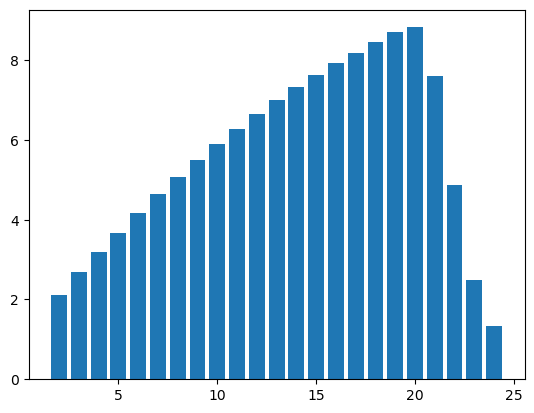

In [120]:
plt.bar(ne[2],np.log10(nh[3].sum(axis=0).sum(axis=0)))

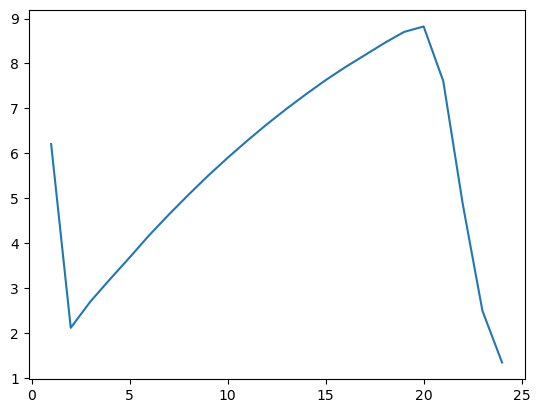

In [99]:
plt.plot(ne[2],np.log10(nh.sum(axis=0).sum(axis=0)))

# plot

## mag distribution

original

In [6]:
de1 = np.load('gaia_fullsky_mag_density_allband_clear_1_001_2-25.edge.npy',allow_pickle=True)
d1 = np.load('gaia_fullsky_mag_density_allband_clear_1_001_2-25.npy')

/tmp/ipykernel_6933/3231646026.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.plot(de1[2][:-1][::10],np.log10(100*d1[0,:,:,:].sum(axis=0).sum(axis=0)[::10]),'g',label='g')
/tmp/ipykernel_6933/3231646026.py:6: RuntimeWarning: divide by zero encountered in log10
  plt.plot(de1[2][:-1][::10],np.log10(100*d1[1,:,:,:].sum(axis=0).sum(axis=0)[::10]),'r',label='rp')
/tmp/ipykernel_6933/3231646026.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.plot(de1[2][:-1][::10],np.log10(100*d1[2,:,:,:].sum(axis=0).sum(axis=0)[::10]),'b',label='bp')


['$ 10^1 $', '$ 10^2 $', '$ 10^3 $', '$ 10^4 $', '$ 10^5 $', '$ 10^6 $', '$ 10^7 $', '$ 10^8 $', '$ 10^9 $']


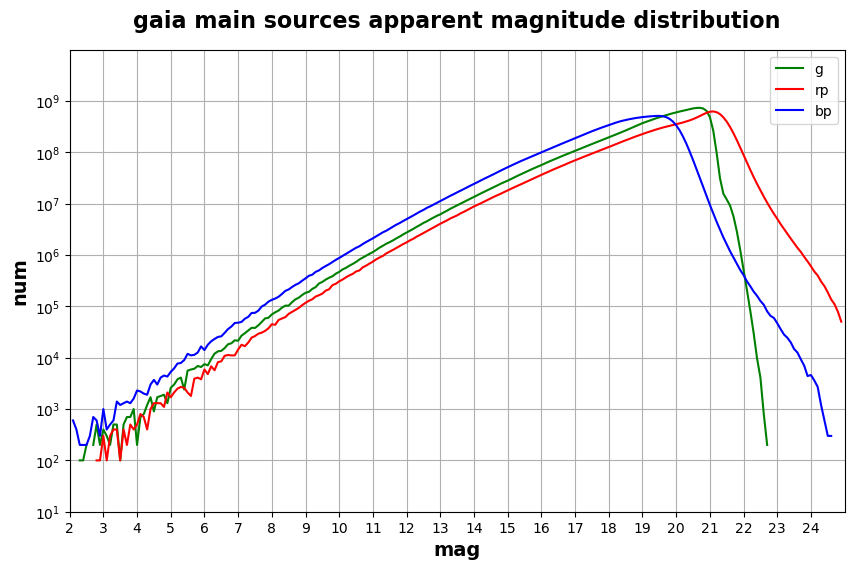

In [201]:
plt.figure(figsize=(10,6))
plt.title('gaia main sources apparent magnitude distribution',fontsize=16,weight='bold',y=1.03)
# plt.bar(de1[2][:-1][200:1800:10],100*d1[0,:,:,:].sum(axis=0).sum(axis=0)[200:1800:10],
#         color=None,edgecolor='g',width=0.01,label='data',log=True)
plt.plot(de1[2][:-1][::10],np.log10(100*d1[0,:,:,:].sum(axis=0).sum(axis=0)[::10]),'g',label='g')
plt.plot(de1[2][:-1][::10],np.log10(100*d1[1,:,:,:].sum(axis=0).sum(axis=0)[::10]),'b',label='bp')
plt.plot(de1[2][:-1][::10],np.log10(100*d1[2,:,:,:].sum(axis=0).sum(axis=0)[::10]),'r',label='rp')
plt.xticks(np.arange(2,25,1))
ytick = []
for i in range(9):
    ytick.append(r'$ 10^%01d $'%(i+1))
print(ytick)
plt.yticks(np.arange(1,10,1),ytick)
plt.xlim(2,25)
plt.ylim(1,10)
plt.legend()
plt.grid(color='0.75')
plt.ylabel('num',fontsize=14,weight='bold')
plt.xlabel('mag',fontsize=14,weight='bold')
plt.savefig('gaia_ms_amag_distribution.png',bbox_inches='tight')

alternative func

In [ ]:
# plt.step()
# plt.bar()

### fit

In [19]:
from scipy.optimize import curve_fit

* lg n = lg m + b

In [74]:
# def logfit(x,base,k,b):
#     return np.log(x)/np.log(base)*k+b
#     # return base*x+b
def logfit(x,base,b):
    return np.log(x)/np.log(base)+b
    # return base*x+b

x = de1[2][:-1][500:1800]
y = np.log10(d1[0,:,:,:].sum(axis=0).sum(axis=0))
y[np.isinf(y)]=-1e20
y = y[500:1800]
p0 = [10,0]
# p0 = [10,1,0]
para,cov = curve_fit(logfit,x,y,p0,)
para,cov

/tmp/ipykernel_6933/2119536834.py:9: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(d1[0,:,:,:].sum(axis=0).sum(axis=0))
/tmp/ipykernel_6933/2119536834.py:5: RuntimeWarning: invalid value encountered in log
  return np.log(x)/np.log(base)+b


(array([ 1.26034345, -6.23015388]),
 array([[1.38452609e-07, 5.25398993e-06],
        [5.25398993e-06, 2.02025627e-04]]))

<BarContainer object of 1300 artists>

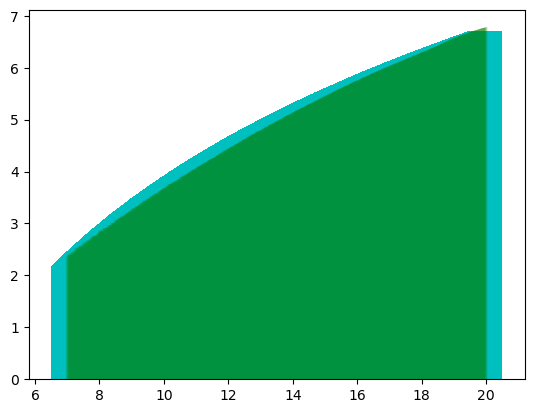

In [77]:
# plt.bar(x,np.log10(logfit(x,para[0],para[1],para[2])))
plt.bar(x,logfit(x,para[0],para[1]),width=1,color='c')
plt.bar(x,y,width=0.1,color='g',alpha=0.1)

* k*(x+a)^base+b

In [71]:
def logfit(x,base,b,k,a):
    return k*(x+a)**base+b

x = de1[2][:-1][500:1800]
y = d1[0,:,:,:].sum(axis=0).sum(axis=0)
y = y[500:1800]
p0 = [10,0,1,0]
# p0 = [10,1,0]
para,cov = curve_fit(logfit,x,y,p0,maxfev=1000000)
para,cov

(array([ 8.54410652e+00,  7.41656299e+03,  2.94562686e-04, -3.84050416e+00]),
 array([[ 3.88358161e-02, -1.50358723e+02, -4.21021159e-05,
          6.66278831e-02],
        [-1.50358723e+02,  2.01597709e+06,  1.64947101e-01,
         -2.70539073e+02],
        [-4.21021159e-05,  1.64947101e-01,  4.56530613e-08,
         -7.22928758e-05],
        [ 6.66278831e-02, -2.70539073e+02, -7.22928758e-05,
          1.14687533e-01]]))

<BarContainer object of 1300 artists>

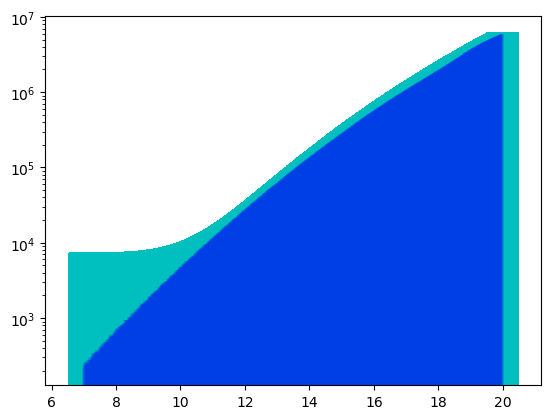

In [73]:
plt.bar(x,logfit(x,para[0],para[1],para[2],para[3]),width=1,color='c')
# plt.bar(x,y,log=True,width=0.1,color='b',alpha=0.1)
plt.bar(x,y,width=0.1,color='b',alpha=0.1,log=True)

* n = (k*m + b)^base

[ 9.13687633  0.3217082  -0.89189198] [[ 0.02956535 -0.0027123   0.02358763]
 [-0.0027123   0.00024892 -0.00216579]
 [ 0.02358763 -0.00216579  0.01885442]]
pre in mag 30:   408555273.7443516


/tmp/ipykernel_6933/561007132.py:2: RuntimeWarning: invalid value encountered in power
  return (k*x+a)**base


(0.01, 10000000.0)

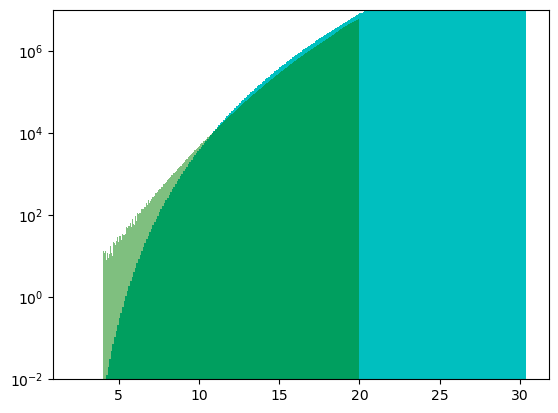

In [93]:
def logfit(x,base,k,a):
    return (k*x+a)**base

x = de1[2][:-1][200:1800]
y = d1[0,:,:,:].sum(axis=0).sum(axis=0)
y = y[200:1800]
p0 = [18,1,0]
para,cov = curve_fit(logfit,x,y,p0,maxfev=1000000)
print(para,cov)
print('pre in mag 30:  ',logfit(30,para[0],para[1],para[2])/1e8)
plt.bar(np.arange(2,30,0.1),logfit(np.arange(2,30,0.1),para[0],para[1],para[2]),width=1,color='c')
plt.bar(x,y,width=0.01,color='g',alpha=0.5,log=True)
plt.ylim(1e-2,1e7)

* lg n = lg m * k + b

[ 2.3042714   7.47357234 -5.08481907] [[-6.94975711e+10 -2.70022681e+11  4.49339184e+02]
 [-2.70022681e+11 -1.04913376e+12  1.74584144e+03]
 [ 4.49340620e+02  1.74584701e+03  5.88103471e-04]]
pre in mag 30:   1.3794809742396301


<BarContainer object of 1600 artists>

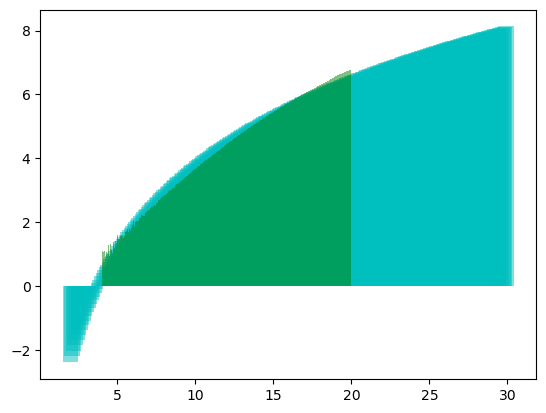

In [107]:
def logfit(x,base,k,b):
    return np.log10(x)/np.log(base)*k+b

x = de1[2][:-1][200:1800]
y = np.log10(d1[0,:,:,:].sum(axis=0).sum(axis=0)[200:1800])
p0 = [1.2,1,0]
para,cov = curve_fit(logfit,x,y,p0,maxfev=1000000)
print(para,cov)
print('pre in mag 30:  ',10**(logfit(30,para[0],para[1],para[2]))/1e8)
plt.bar(np.arange(2,30,0.1),logfit(np.arange(2,30,0.1),para[0],para[1],para[2]),width=1,color='c',alpha=0.5)
plt.bar(x,y,width=0.01,color='g',alpha=0.5)

* lg n = m * k + b

[ 0.36744117 -0.16997524] [[ 9.88513685e-07 -1.18572208e-05]
 [-1.18572208e-05  1.63315617e-04]]
pre in mag 30:   713.2798321891943


<BarContainer object of 1600 artists>

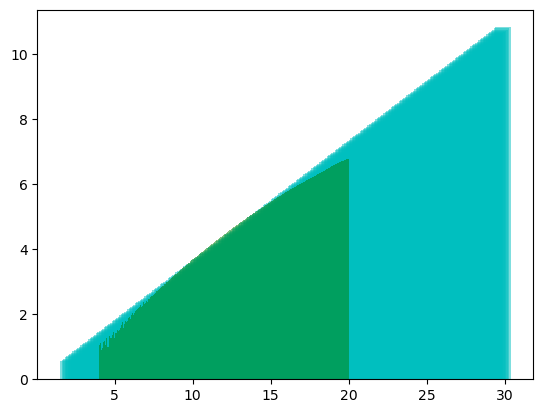

In [108]:
def logfit(x,k,b):
    return x*k+b

x = de1[2][:-1][200:1800]
y = np.log10(d1[0,:,:,:].sum(axis=0).sum(axis=0)[200:1800])
p0 = [1,0]
para,cov = curve_fit(logfit,x,y,p0,maxfev=1000000)
print(para,cov)
print('pre in mag 30:  ',10**(logfit(30,para[0],para[1]))/1e8)
plt.bar(np.arange(2,30,0.1),logfit(np.arange(2,30,0.1),para[0],para[1]),width=1,color='c',alpha=0.5)
plt.bar(x,y,width=0.01,color='g',alpha=0.5)

* lg n = a m^2 + b m + c

[-0.00940304  0.5930201  -1.32228673] [[ 2.59251052e-09 -6.21943270e-08  3.17703605e-07]
 [-6.21943270e-08  1.53628734e-06 -8.15243355e-06]
 [ 3.17703605e-07 -8.15243355e-06  4.62434661e-05]]
pre in mag 30:   1.0129321792548989


<BarContainer object of 1600 artists>

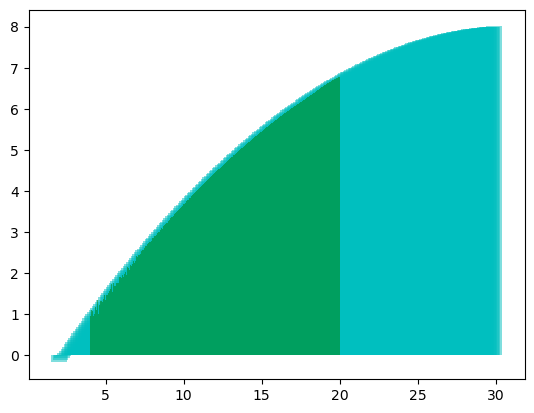

In [118]:
def logfit(x,a,b,c):
    return a*x**2+b*x+c

x = de1[2][:-1][200:1800]
y = np.log(d1[0,:,:,:].sum(axis=0).sum(axis=0)[200:1800])/np.log(10)
p0 = [-3,100,0]
para,cov = curve_fit(logfit,x,y,p0,maxfev=1000000)
print(para,cov)
print('pre in mag 30:  ',10**(logfit(30,para[0],para[1],para[2]))/1e8)
plt.bar(np.arange(2,30,0.1),logfit(np.arange(2,30,0.1),para[0],para[1],para[2]),width=1,color='c',alpha=0.5)
plt.bar(x,y,width=0.01,color='g',alpha=0.5)

In [110]:
1/np.log10(1.26)

9.963082285034032

## fullsky density

In [132]:
de2 = np.load('gaia_fullsky_mag_density_allband_skyclear_02_01_10-20.5.edge.npy',allow_pickle=True)
d2 = np.load('gaia_fullsky_mag_density_allband_skyclear_02_01_10-20.5.npy')

NameError: name 'd2' is not defined

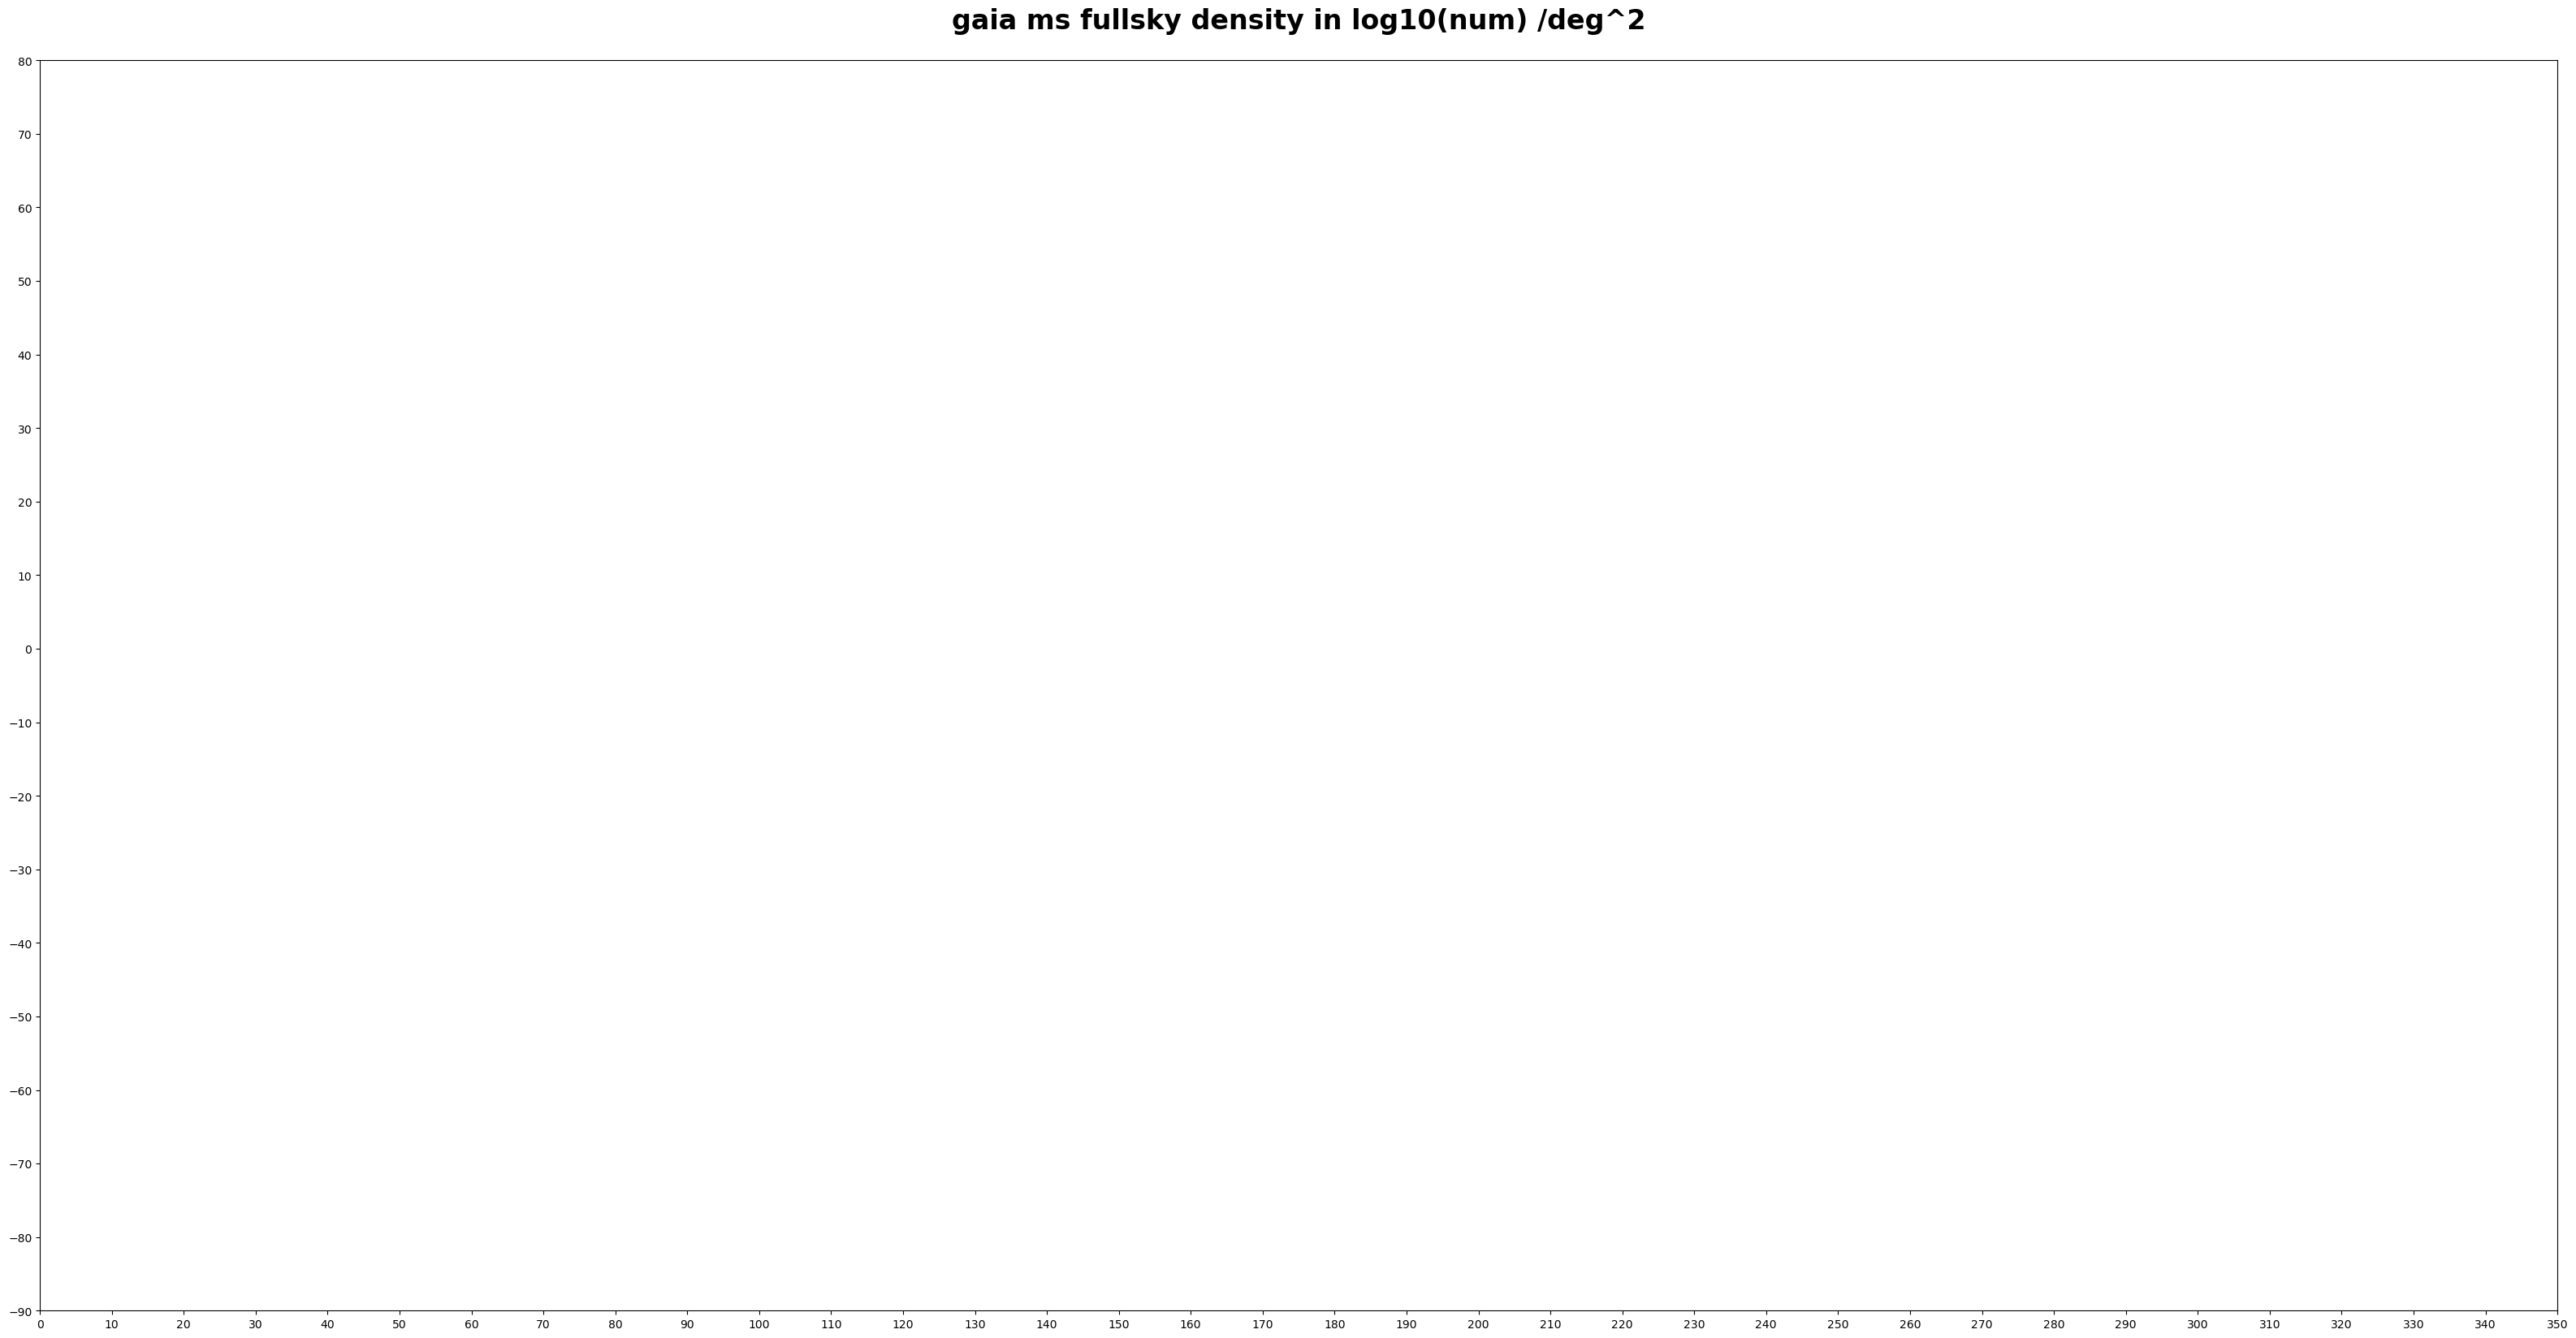

In [2]:
plt.figure(figsize=(40,20))
plt.title('gaia ms fullsky density in log10(num) /deg^2',fontsize=24,weight='bold',y=1.02)
plt.yticks(np.arange(-90,90,10))
plt.xticks(np.arange(0,360,10))
pic = np.log10(d2[3,:,:,:].sum(axis=2).T*25)
pic[np.isinf(pic)]=0
plt.imshow(pic,cmap='ocean',extent=(0,360,-90,90),origin='lower')
plt.colorbar(shrink=0.80,pad=0.02)
plt.savefig('./gaia_ms_fullsky_density_log10_deg2.png',bbox_inches='tight',dpi=500)

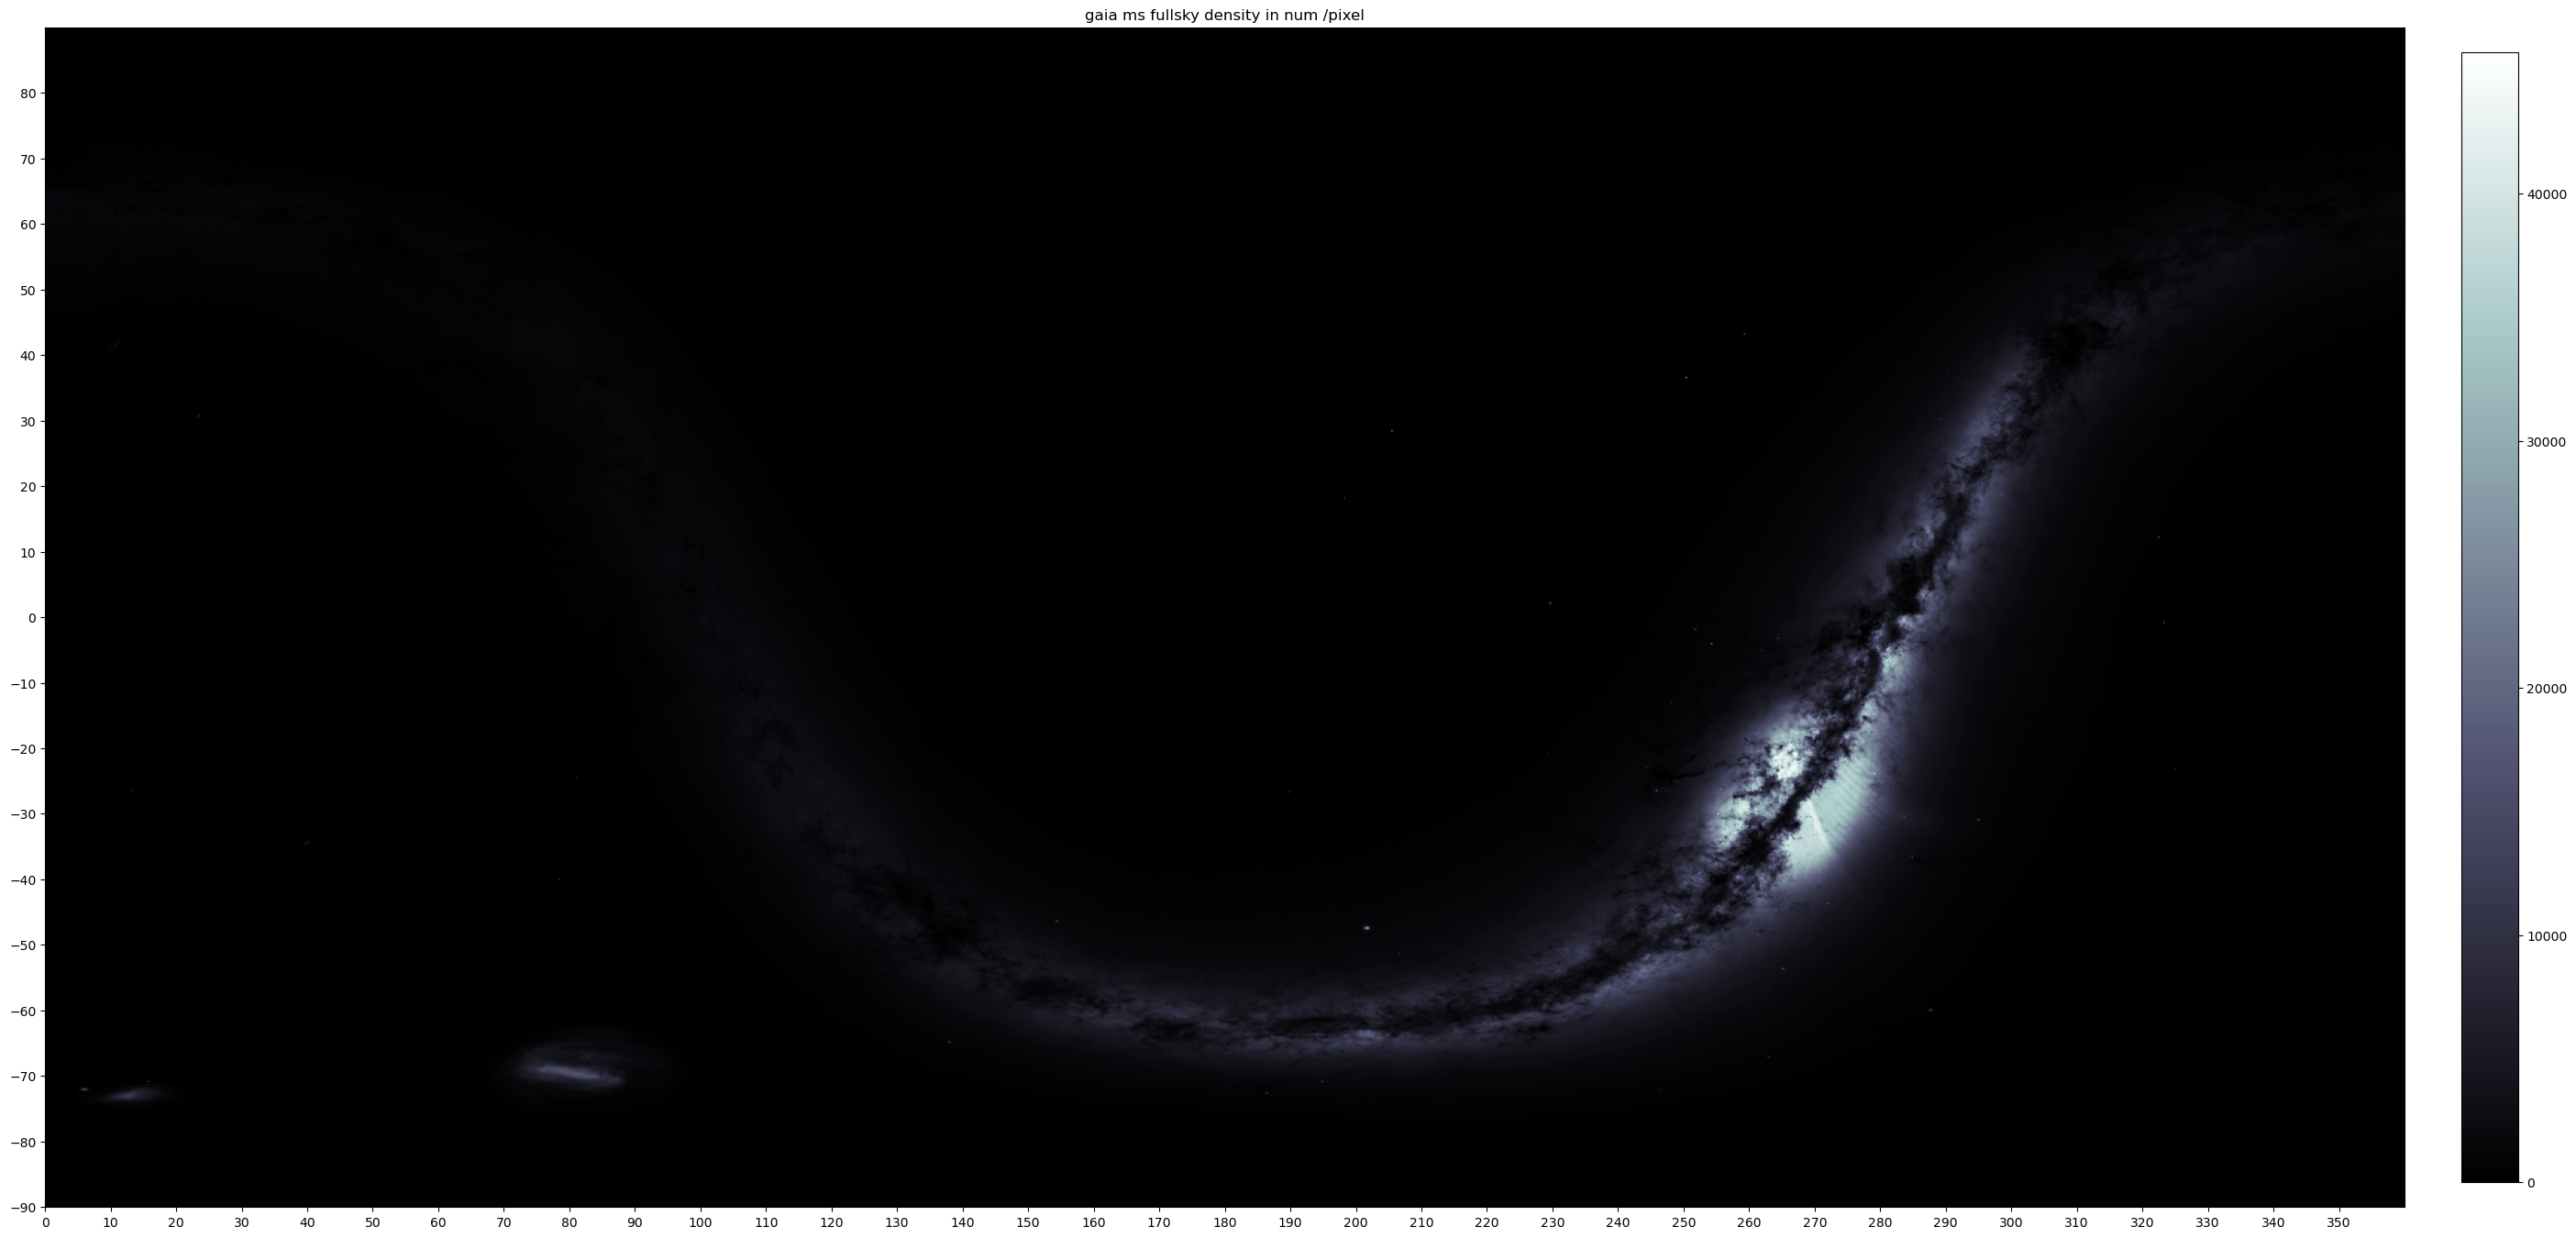

In [196]:
plt.figure(figsize=(40,20))
plt.title('gaia ms fullsky density in num /pixel')
plt.yticks(np.arange(-90,90,10))
plt.xticks(np.arange(0,360,10))
pic = d2[3,:,:,:].sum(axis=2).T/(0.2*0.2/(0.074*0.074*9232*9216/3600/3600))
plt.imshow(pic,cmap='bone',extent=(0,360,-90,90),origin='lower')
plt.colorbar(shrink=0.80,pad=0.02)
plt.savefig('./gaia_ms_fullsky_density_pixel.png',bbox_inches='tight')

In [3]:
de3 = np.load('gaia_fullsky_density_map_0.01.edge.npy',allow_pickle=True)
d3 = np.load('gaia_fullsky_density_map_0.01.npy')


In [ ]:

plt.figure(figsize=(40,20))
plt.title('gaia ms fullsky density in log10(num) /deg^2',fontsize=24,weight='bold',y=1.02)
plt.yticks(np.arange(-90,90,10))
plt.xticks(np.arange(0,360,10))
pic = np.log10(d3.T*1000)
pic[np.isinf(pic)]=0
plt.imshow(pic,cmap='PuBu_r',extent=(0,360,-90,90),origin='lower')
plt.colorbar(shrink=0.80,pad=0.02)
plt.savefig('./gaia_ms_fullsky_density_show_log10.png',bbox_inches='tight')

/tmp/ipykernel_5362/2410968626.py:5: RuntimeWarning: divide by zero encountered in log10
  pic = np.log10(d3.T / (0.01*0.01/(0.074*0.074*9232*9216/3600/3600)))


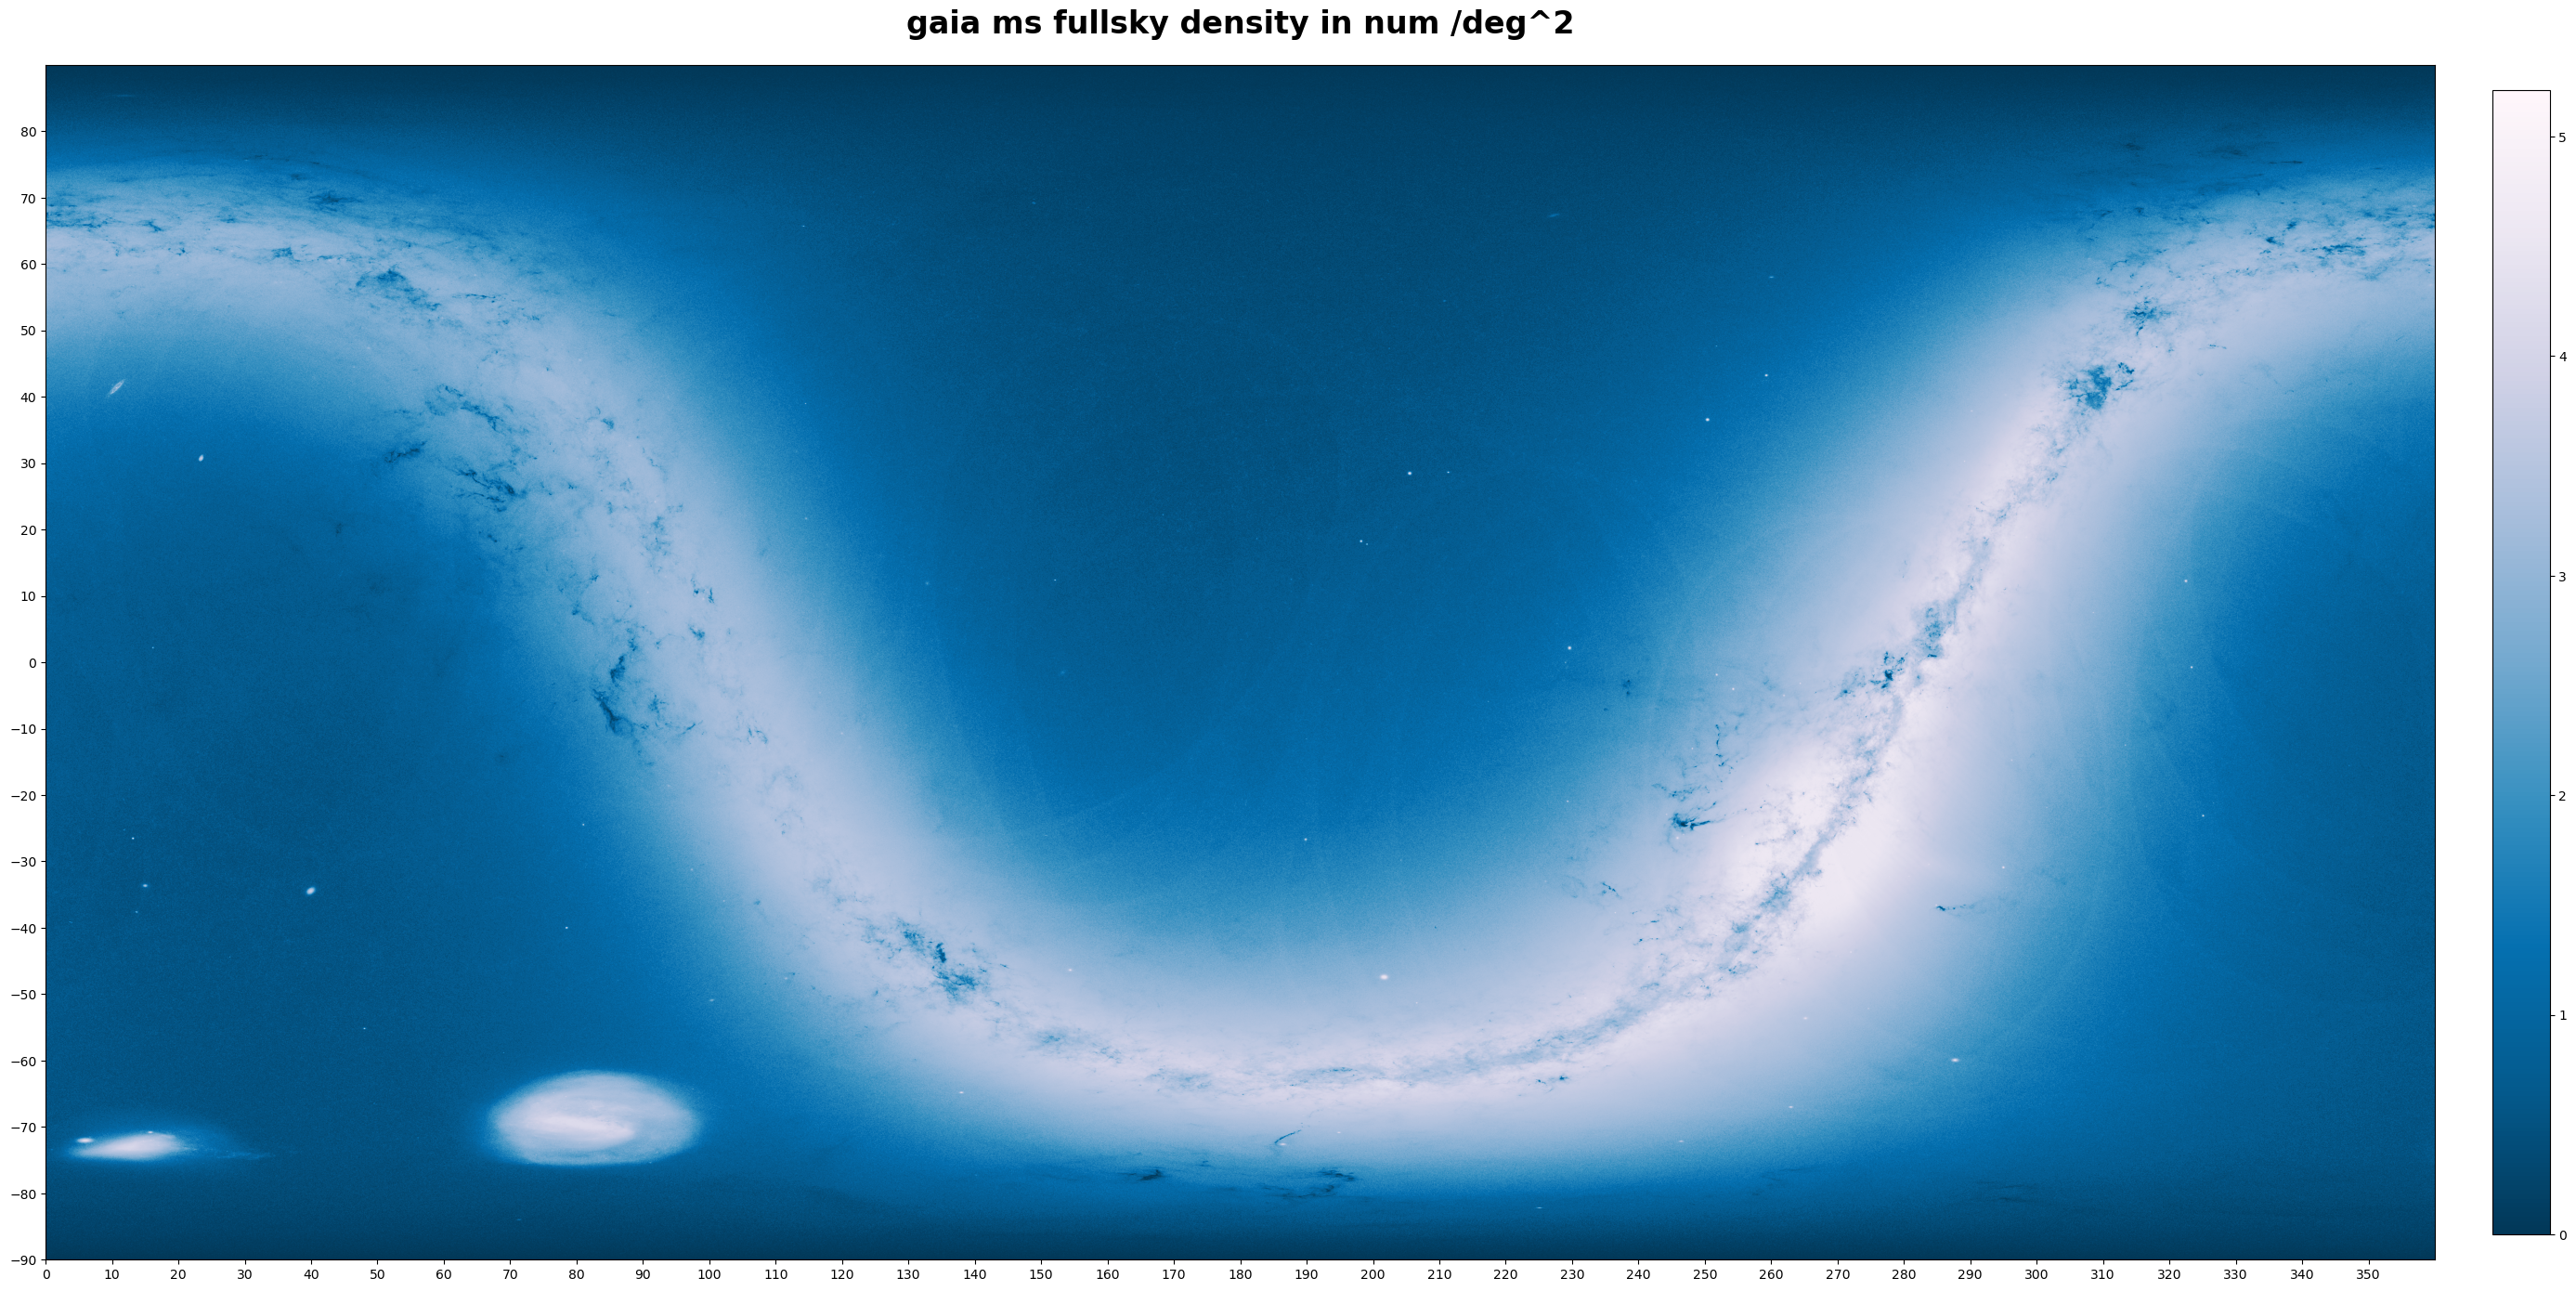

In [8]:
plt.figure(figsize=(40,20))
plt.title('gaia ms fullsky density in num /deg^2',fontsize=24,weight='bold',y=1.02)
plt.yticks(np.arange(-90,90,10))
plt.xticks(np.arange(0,360,10))
pic = np.log10(d3.T / (0.01*0.01/(0.074*0.074*9232*9216/3600/3600)))
pic[np.isinf(pic)]=0
plt.imshow(pic,cmap='PuBu_r',extent=(0,360,-90,90),origin='lower')
plt.colorbar(shrink=0.80,pad=0.02)
plt.savefig('./gaia_ms_fullsky_density_show_CCD.png',bbox_inches='tight',dpi=500)

In [7]:
d3.mean()/(0.01*0.01/(0.074*0.074*9232*9216/3600/3600))

1005.1024243813996

## kong

1.1126620906352982

In [148]:
0.074*9232/3600

0.1897688888888889

# debug

In [25]:
dty = np.uint32

def float2index(d,bin,min=0):
    # d = d.fillna(99)  # fill nan in mag with value 99.
    return dty((d-min)/bin)

def density_sky_mag_calculationt(data='a',coor='icrs',bin_sky=1,m_min=1, m_max=25, bin_mag=0.01):
    # read path
    with open('/media/hyz/dwarfcave/data/gaiaDR3/ms/gaiasource_path.list','r') as _list:
        path = _list.readlines()
        if type(data) == int:
            path = path[0:data]
        elif data == 'a':
            pass
        
    # make grid
    bins_sky = np.arange(0,360,bin_sky).size
    bins_mag = np.arange(m_min,m_max,bin_mag).size
    count    = np.zeros((int(bins_sky/2),bins_sky,bins_mag,4),dtype=dty)  # ra,dec,[mag]. mag:(in colume) magbins g rp bp mean

    # sky_ax = np.array(np.meshgrid(np.arange(0,360,1),np.flip(np.arange(-90,90,1))),dtype=np.float32).T
    
    # statistics
    for _,_line in enumerate(path):
        _p = _line.strip()
        # read
        print("reading: %s  ==> "%_,_p)
        _d    = pd.read_csv(_p,comment='#',usecols=['ra','dec','phot_g_mean_mag','phot_rp_mean_mag','phot_bp_mean_mag'])

        print('1')
        _d['mag_mean'] = _d[['phot_g_mean_mag','phot_rp_mean_mag','phot_bp_mean_mag']].mean(axis=1)  # calculate mean of 3 band. obtain all objects
        _d = _d.fillna(1)
        print('2')
        # index
        _bin  = [bin_sky,bin_sky,bin_mag,bin_mag,bin_mag,bin_mag]
        _min  = [0, -90, m_min, m_min, m_min, m_min]
        _d    = float2index(_d, _bin, _min)
        print('3')
        # region
        _mml  = np.array([np.arange(_d[:,0].min(),_d[:,0].max(),1),   # seperatly ra, dec, g, rp, bp, mean
                          np.arange(_d[:,1].min(),_d[:,1].max(),1),
                          np.arange(_d[:,2].min(),_d[:,2].max(),1),
                          np.arange(_d[:,3].min(),_d[:,3].max(),1),
                          np.arange(_d[:,4].min(),_d[:,4].max(),1),
                          np.arange(_d[:,5].min(),_d[:,5].max(),1)])  # lengths of these series are not identity, so dtype is object.
        print('4')
        # add
        for _de in _mml[1]:                                                                     # dec
            for _r in _mml[0]:                                                                 # ra
                if _de%10==0 and _r%10==0:
                    print(_de,_r)
                for _m in _mml[2]:
                    count[_de,_r,_m,0] += np.sum((_d[:,0]==_r) & (_d[:,1]==_de) & (_d[:,2]==_m))  # g
                for _m in _mml[3]:
                    count[_de,_r,_m,1] += np.sum((_d[:,0]==_r) & (_d[:,1]==_de) & (_d[:,2]==_m))  # rp
                for _m in _mml[4]:
                    count[_de,_r,_m,2] += np.sum((_d[:,0]==_r) & (_d[:,1]==_de) & (_d[:,2]==_m))  # bp
                for _m in _mml[5]:
                    count[_de,_r,_m,3] += np.sum((_d[:,0]==_r) & (_d[:,1]==_de) & (_d[:,2]==_m))  # mean
    
    magax = np.arange(m_min,m_max,bin_mag,dtype=np.float32)
    # coordinate alternation
    if coor == 'icrs':
        return [magax, count]
    elif coor == 'gal':
        grid_ra = np.arange(0,360,bin)
        grid_dec = np.arange(-90,90,bin)
        grid_icrs = SkyCoord(grid_ra,grid_dec,frame='icrs',unit='deg')
        grid_gal = grid_icrs.galactic
        count = grid_gal.to_string('decimal')
        return magax, count
    else:
        print('coordination assign is out of index, please choose "icrs" or "gal".')
        
if __name__ == '__main__':
    result = density_sky_mag_calculationt(1,bin_mag=0.1)


reading: 0  ==>  /media/hyz/dwarfcave/data/gaiaDR3/ms/GaiaSource_000000-003111.csv
1
2
3
4


/tmp/ipykernel_697761/30824763.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _mml  = np.array([np.arange(_d[:,0].min(),_d[:,0].max(),1),   # seperatly ra, dec, g, rp, bp, mean


90 40
90 50
100 40
100 50


In [85]:
_d = pd.read_csv('/media/hyz/dwarfcave/data/gaiaDR3/ms/GaiaSource_786097-786431.csv',comment='#',usecols=['ra','dec','phot_g_mean_mag'])
_d = _d.fillna(1)

In [94]:
_d.to_numpy()

array([[ 3.10957073e+02, -4.62478978e+00,  1.84575710e+01],
       [ 3.10959454e+02, -4.62530269e+00,  1.87353920e+01],
       [ 3.10958499e+02, -4.61632481e+00,  1.63321480e+01],
       ...,
       [ 3.15005038e+02, -5.73822138e-03,  1.93482000e+01],
       [ 3.14999051e+02, -2.57115560e-03,  1.95117110e+01],
       [ 3.15003638e+02, -6.75881764e-03,  1.85618040e+01]])

In [53]:
dd = np.histogramdd(_d.to_numpy(),np.array([360,180,240]),range=([0,360],[-90,90],[1,25]))

In [59]:
np.where(dd[0]>0)

(array([310, 310, 310, ..., 317, 317, 317]),
 array([85, 85, 85, ..., 88, 88, 88]),
 array([  0,  79,  80, ..., 204, 205, 206]))

In [107]:
np.histogramdd(np.empty((1,3)),np.array([360,180,240]),range=([0,360],[-90,90],[1,25]))[1]

[array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
         44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
         55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
         66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
         77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
         88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
         99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
        110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
        121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
        132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
        143., 144., 145., 146., 147., 

In [4]:
dd = np.load('gaia_fullsky_mag_density_allband_clear.npy')

In [5]:
de = np.load('gaia_fullsky_mag_density_allband_clear.edge.npy',allow_pickle=True)

In [6]:
dd.shape

(4, 360, 180, 2300)

In [74]:
de

array([array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
               11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
               22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
               33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
               44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
               55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
               66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
               77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
               88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
               99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
              110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
              121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
              132., 133., 134., 135., 13

/tmp/ipykernel_22679/867038793.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.plot(xax.T,np.log10(dd[:,280,70,:]).T)


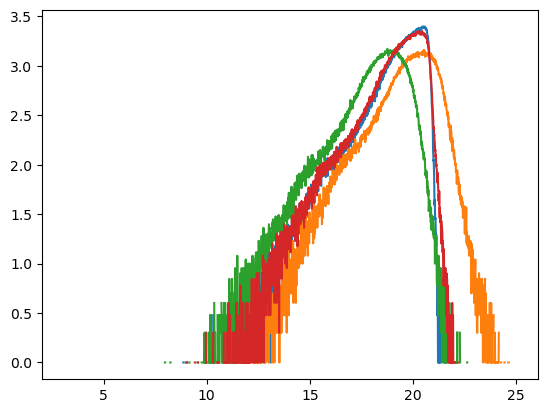

In [9]:
xax = de[2][:-1]
xax = np.vstack((xax,xax,xax,xax))
plt.plot(xax.T,np.log10(dd[:,280,70,:]).T)

In [22]:
dd[3,280,70,:][1800:1900]

array([2006, 2013, 2037, 2109, 2018, 2012, 2023, 2064, 2101, 2122, 2088,
       2024, 2120, 2025, 2117, 2063, 2188, 2187, 2110, 2111, 2188, 2180,
       2171, 2153, 2181, 2165, 2158, 2237, 2203, 2167, 2168, 2129, 2147,
       2078, 2187, 2195, 2150, 2137, 2179, 2116, 2106, 2054, 2195, 2115,
       2202, 2253, 2163, 2142, 2082, 2075, 2104, 2138, 2084, 2088, 2084,
       2130, 1999, 2043, 2098, 1976, 1963, 2039, 2011, 1953, 1937, 1896,
       1905, 1889, 1867, 1857, 1705, 1740, 1654, 1628, 1513, 1500, 1460,
       1348, 1330, 1268, 1229, 1123, 1059,  998,  956,  834,  829,  730,
        780,  687,  618,  590,  517,  520,  429,  407,  388,  340,  302,
        283], dtype=uint16)

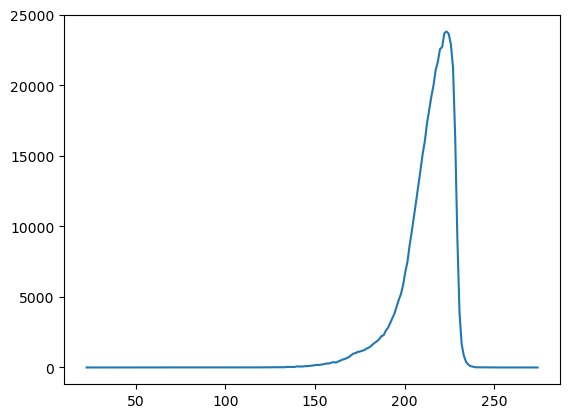

In [69]:
plt.plot(sr(de[2][0:-1],11),sr(dd[3,280,70,:],11))

In [2]:
fmdr = np.load('/home/hyz/da/gaia/density_statistics/gaia_fullsky_mag_density_rough.npy')

In [3]:
fmdr.max()

72772

In [4]:
np.arange(8e4,dtype=np.uint16).max()

65535